In [2]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


SNR (Noisy ECG): 8.73 dB, MSE (Noisy ECG): 0.0050
SNR (Filtered ECG): -0.04 dB, MSE (Filtered ECG): 0.0377


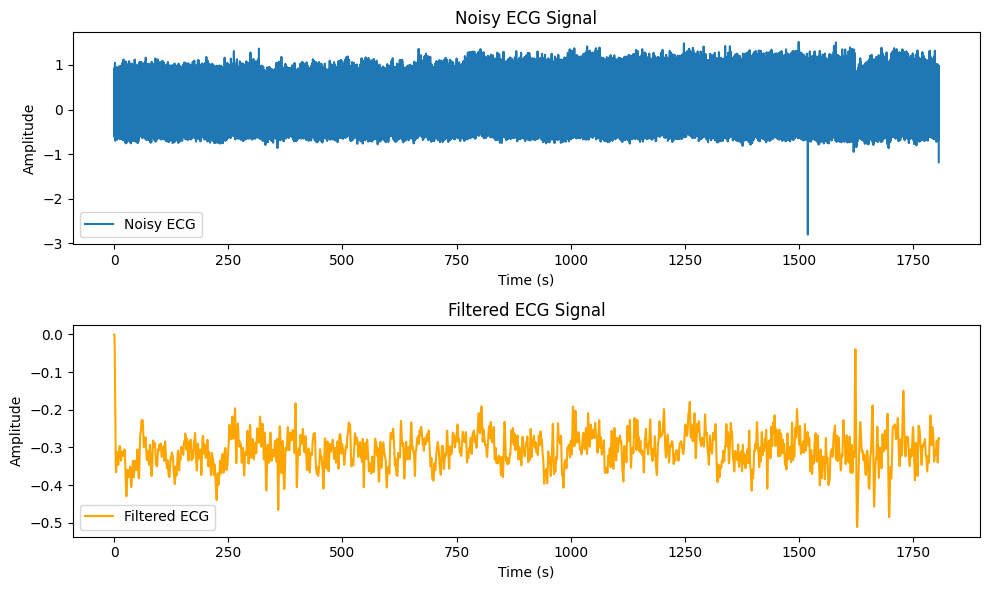

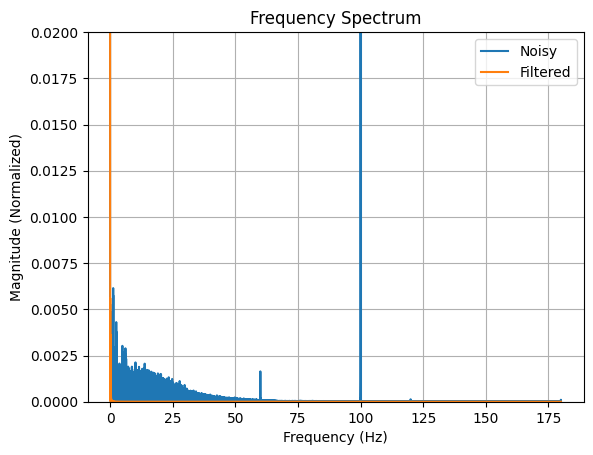

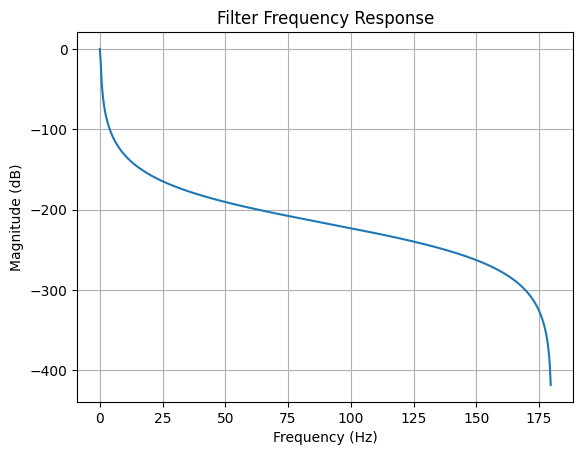

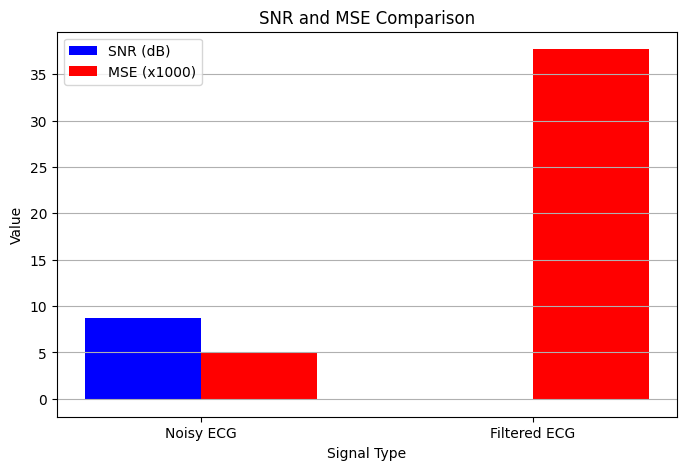

In [7]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wfdb

# Load ECG data (MIT-BIH)
try:
    record = wfdb.rdrecord('100', pn_dir='mitdb')  # Download record 100
    ecg = record.p_signal[:, 0]  # Single-channel ECG
    fs = record.fs  # 360 Hz
except Exception as e:
    print(f"Error loading MIT-BIH data: {e}")
    print("Please ensure 'wfdb' is installed ('pip install wfdb') and internet is available.")
    print("Alternatively, run in Google Colab or check https://physionet.org/content/mitdb.")
    raise

# Add synthetic noise
t = np.arange(len(ecg)) / fs
noise = 0.1 * np.sin(2 * np.pi * 100 * t)  # 100 Hz noise
noisy_ecg = ecg + noise

# Design low-pass Butterworth filter
b, a = signal.butter(4, 40/(fs/2), btype='low', fs=fs)
filtered_ecg = signal.lfilter(b, a, noisy_ecg)

# Compute SNR and MSE
snr_noisy = 10 * np.log10(np.var(ecg) / np.var(noisy_ecg - ecg))
mse_noisy = np.mean((noisy_ecg - ecg) ** 2)
snr_filtered = 10 * np.log10(np.var(ecg) / np.var(filtered_ecg - ecg))
mse_filtered = np.mean((filtered_ecg - ecg) ** 2)
print(f"SNR (Noisy ECG): {snr_noisy:.2f} dB, MSE (Noisy ECG): {mse_noisy:.4f}")
print(f"SNR (Filtered ECG): {snr_filtered:.2f} dB, MSE (Filtered ECG): {mse_filtered:.4f}")

# Plot time-domain signals
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, noisy_ecg, label='Noisy ECG')
plt.title('Noisy ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(t, filtered_ecg, label='Filtered ECG', color='orange')
plt.title('Filtered ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.savefig('ecg_time.png')
plt.show()

# Plot frequency spectrum (adjusted for visibility)
freq = np.fft.fftfreq(len(ecg), 1/fs)
fft_noisy = np.abs(np.fft.fft(noisy_ecg)) / len(ecg)  # Normalize by signal length
fft_filtered = np.abs(np.fft.fft(filtered_ecg)) / len(ecg)  # Normalize by signal length
plt.figure()
plt.plot(freq[:len(freq)//2], fft_noisy[:len(freq)//2], label='Noisy')
plt.plot(freq[:len(freq)//2], fft_filtered[:len(freq)//2], label='Filtered')
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (Normalized)')
plt.legend()
plt.grid()
plt.ylim(0, 0.02)  # Adjust y-axis limit to focus on relevant magnitude range
plt.savefig('ecg_freq.png')
plt.show()

# Plot filter response
w, h = signal.freqz(b, a, fs=fs)
plt.figure()
plt.plot(w, 20 * np.log10(abs(h)))
plt.title('Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.savefig('filter_response.png')
plt.show()

# Bar chart for SNR and MSE comparison
labels = ['Noisy ECG', 'Filtered ECG']
snrs = [snr_noisy, snr_filtered]
mses = [mse_noisy * 1000, mse_filtered * 1000]  # Scale MSE for visibility
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, snrs, width, label='SNR (dB)', color='blue')
plt.bar(x + width/2, mses, width, label='MSE (x1000)', color='red')
plt.xlabel('Signal Type')
plt.ylabel('Value')
plt.title('SNR and MSE Comparison')
plt.xticks(x, labels)
plt.legend()
plt.grid(True, axis='y')
plt.savefig('comparison_chart.png')
plt.show()